In [ ]:
# Import necessary libraries
import os

# Mount your Google Drive (You'll be prompted to authorize access)
from google.colab import drive
drive.mount('/content/drive')

# List files in a directory in your Google Drive
directory_path = '/content/drive/My Drive/voc_plate_dataset'

for root, dirs, files in os.walk(directory_path):
    for filename in files:
        print(os.path.join(root, filename))


Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen13.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1333.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1319.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1316.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1328.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1302.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1335.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1381.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1348.jpg
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlateGen1375.jpg
/

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.model_selection import train_test_split
import torch

import os
import glob

import xml.etree.cElementTree as ET

from tqdm.auto import tqdm
import shutil as sh
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Check if a GPU is available
print(torch.cuda.is_available())

# Get the name of the available GPU
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [ ]:
# # Set global variables for dataset paths in Google Drive
# ROOT_PATH = '/content/drive/My Drive'  # The root directory of your Google Drive

# # You should replace 'your-dataset-folder' with the actual folder name in your Google Drive
# DATASET_FOLDER = 'voc_plate_dataset'

# # Define the full paths for annotations and images directories
# DATASET_PATH = os.path.join(ROOT_PATH, DATASET_FOLDER)
# ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# # Print the paths for annotations and images
# print(ANNOTATIONS_PATH)  # Print the path to the annotations directory
# print(IMAGES_PATH)  # Print the path to the images directory

In [ ]:
ANNOTATIONS_PATH = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/Annotations/'
IMAGES_PATH = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/'

# Print the paths for annotations and images
print(ANNOTATIONS_PATH)  # Print the path to the annotations directory
print(IMAGES_PATH)  # Print the path to the images directory

/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/Annotations/
/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/


Image shape: (303, 472, 3)


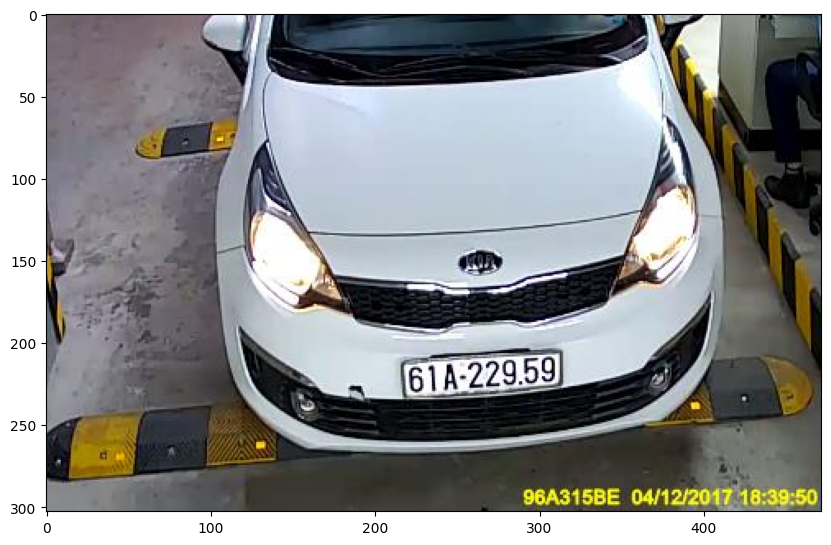

In [ ]:

# Create the full path to the image file
image_path = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/CarLongPlate74.jpg'

# Read the image from the specified file
img = plt.imread(image_path)

# Create a figure and axes for displaying the image
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image on the axes
ax.imshow(img)

# Print the shape of the image (dimensions)
print('Image shape: {}'.format(img.shape))


/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/Annotations/CarLongPlateGen2506.xml

In [ ]:
print(img)

[[[115 104 112]
  [115 104 112]
  [115 104 112]
  ...
  [197 228 233]
  [153 183 194]
  [ 73 105 118]]

 [[114 103 111]
  [114 103 111]
  [114 103 111]
  ...
  [ 43  72  78]
  [ 53  83  94]
  [ 41  73  86]]

 [[113 102 110]
  [113 102 110]
  [113 102 110]
  ...
  [ 33  60  67]
  [ 65  95 106]
  [ 99 128 144]]

 ...

 [[137 138 140]
  [137 138 140]
  [137 138 140]
  ...
  [105 108  89]
  [109 110 112]
  [ 87  87  99]]

 [[137 138 140]
  [137 138 140]
  [137 138 140]
  ...
  [101 105  90]
  [ 99 103 106]
  [ 93  95 107]]

 [[137 138 140]
  [137 138 140]
  [137 138 140]
  ...
  [101 110  79]
  [ 97 103 101]
  [103 107 119]]]


In [ ]:
with open(os.path.join(ANNOTATIONS_PATH, 'CarLongPlateGen2506.xml')) as f:
    print(f.read())

<annotation>
	<folder/>
	<filename>CarLongPlateGen2506.jpg</filename>
	<path>.\data\/CarLongPlateGen2506.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>472</width>
		<height>303</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>plate</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>241</xmin>
			<ymin>221</ymin>
			<xmax>357</xmax>
			<ymax>287</ymax>
		</bndbox>
	</object>
</annotation>



In [ ]:
df_dict = {
    "filename": [], "xmin": [], "ymin": [],
    "xmax": [], "ymax": [], "name": [],
    "width": [], "height": []
}

for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    tree = ET.parse(annotation)
    filename = tree.find('filename').text
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))


        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height]
                    df_dict['filename'] += [filename]

                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]

In [ ]:
df = pd.DataFrame(df_dict)
df.head()

filename  xmin  ymin  xmax  ymax   name  width  height
0  CarLongPlateGen1684.jpg   145    42   249    73  plate    472     303
1  CarLongPlateGen1678.jpg   156   120   265   153  plate    472     303
2  CarLongPlateGen1671.jpg   179   208   277   235  plate    472     303
3  CarLongPlateGen1686.jpg   212   171   308   198  plate    472     303
4  CarLongPlateGen1675.jpg   210   242   286   260  plate    472     303

In [ ]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))

Data shape: (3085, 8)
Count of unique images: 3005
Count of classes: ['plate']


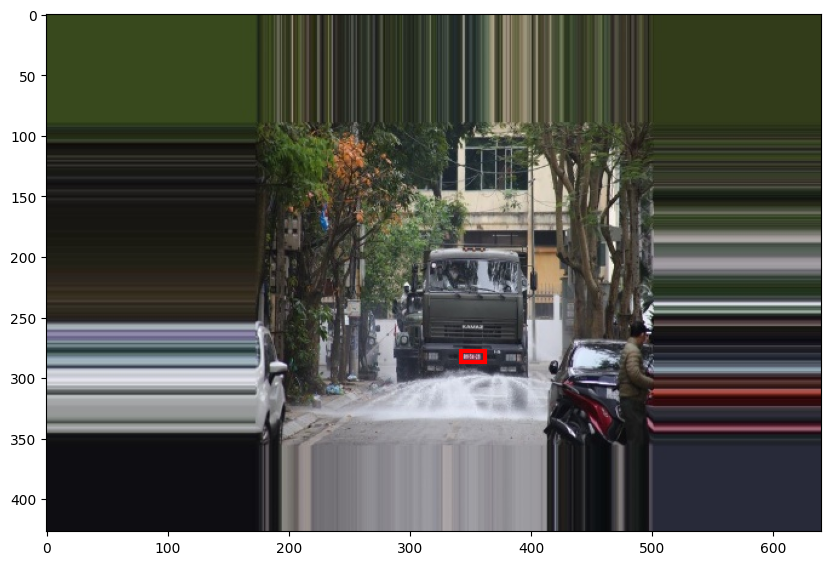

In [ ]:
# Define the filename of the image you want to process
image_filename = 'boderquandoi92.jpg'

# Create the full path to the image file
image_path = os.path.join(IMAGES_PATH, image_filename)

# Read the image from the specified file
img = plt.imread(image_path)

# Create a figure and axes for displaying the image
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image on the axes
ax.imshow(img)

# Get the index of the image in a DataFrame (df) based on the filename
image_idx = df[df['filename'] == image_filename].index

# Extract information about bounding boxes
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values

# Loop through all bounding boxes and draw rectangles
for i in range(len(image_idx)):
    rect = patches.Rectangle(
        (x_min[i], y_min[i]),  # Coordinates of the top-left corner
        box_width[i],  # Width of the rectangle
        box_height[i],  # Height of the rectangle
        linewidth=3,  # Line width
        edgecolor='r',  # Line color (red in this case)
        facecolor='none'  # No fill color (none)
    )
    ax.add_patch(rect)  # Add the rectangle to the image

# The code above adds red bounding boxes to the image based on the coordinates and dimensions
# extracted from a DataFrame (df) for the specified image.


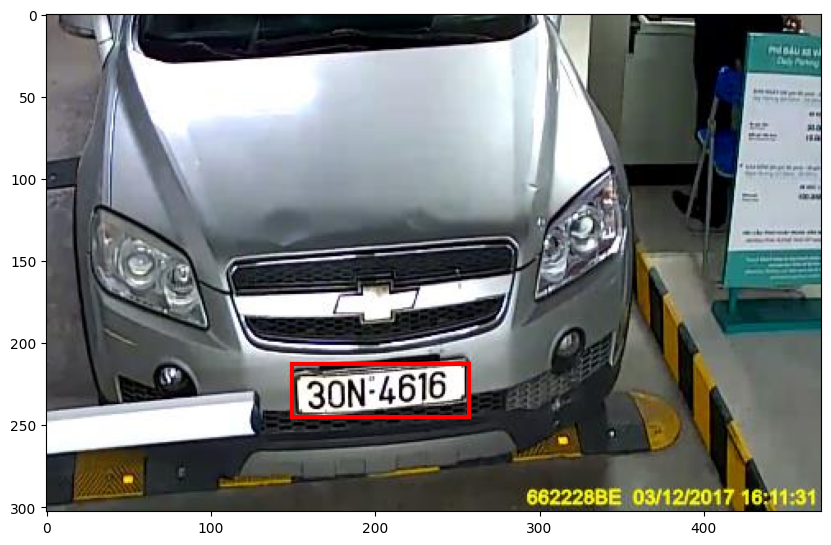

In [ ]:
# Define the filename of the image you want to process
image_filename = 'CarLongPlate434.jpg'

# Create the full path to the image file
image_path = os.path.join(IMAGES_PATH, image_filename)

# Read the image from the specified file
img = plt.imread(image_path)

# Create a figure and axes for displaying the image
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image on the axes
ax.imshow(img)

# Get the index of the image in a DataFrame (df) based on the filename
image_idx = df[df['filename'] == image_filename].index

# Extract information about bounding boxes
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values

# Loop through all bounding boxes and draw rectangles
for i in range(len(image_idx)):
    rect = patches.Rectangle(
        (x_min[i], y_min[i]),  # Coordinates of the top-left corner
        box_width[i],  # Width of the rectangle
        box_height[i],  # Height of the rectangle
        linewidth=3,  # Line width
        edgecolor='r',  # Line color (red in this case)
        facecolor='none'  # No fill color (none)
    )
    ax.add_patch(rect)  # Add the rectangle to the image

# The code above adds red bounding boxes to the image based on the coordinates and dimensions
# extracted from a DataFrame (df) for the specified image.


In [ ]:
def plot_bounding_box(image_folder, image_filename, df=df):
    """
    Function for visualizing an image with bounding boxes.
    """
    # Create the full path to the image
    image_path = os.path.join(image_folder, image_filename)
    # Read the image
    img = plt.imread(image_path)
    # Create a figure and coordinate axes
    fig, ax = plt.subplots(figsize=(10, 8))
    # Display the image
    ax.imshow(img)

    # Find the index of the image in the DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # Find the coordinates of the bottom-left corner
    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    # Find the width and height of the bounding box
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    # Since there may be multiple bounding boxes, loop through all of them
    for i in range(len(image_idx)):
        # Create a rectangle
        rect = patches.Rectangle(
            (x_min[i], y_min[i]),  # Coordinates of the reference point
            box_width[i],  # Width of the rectangle
            box_height[i],  # Height of the rectangle
            linewidth=3,  # Line width
            edgecolor='r',  # Line color (red)
            facecolor='none'  # No fill color (none)
        )
        # Overlay the rectangle on top of the image
        ax.add_patch(rect)


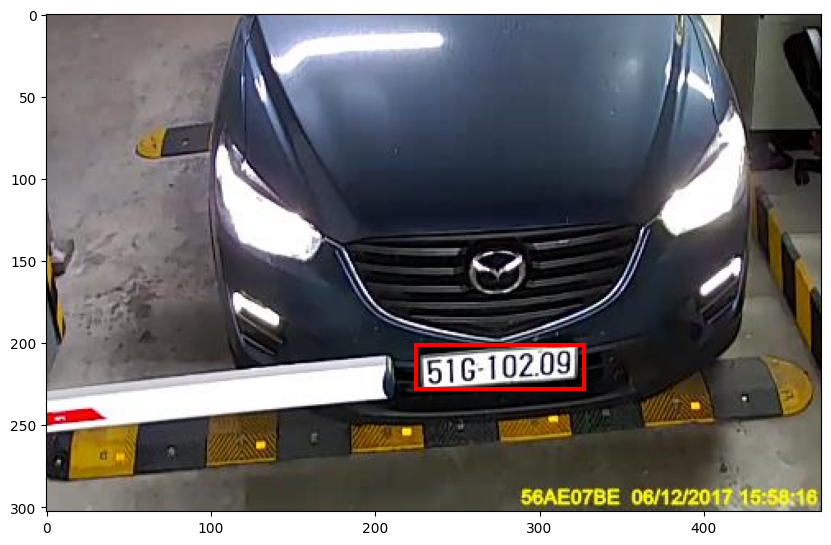

In [ ]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='CarLongPlate455.jpg', df=df)

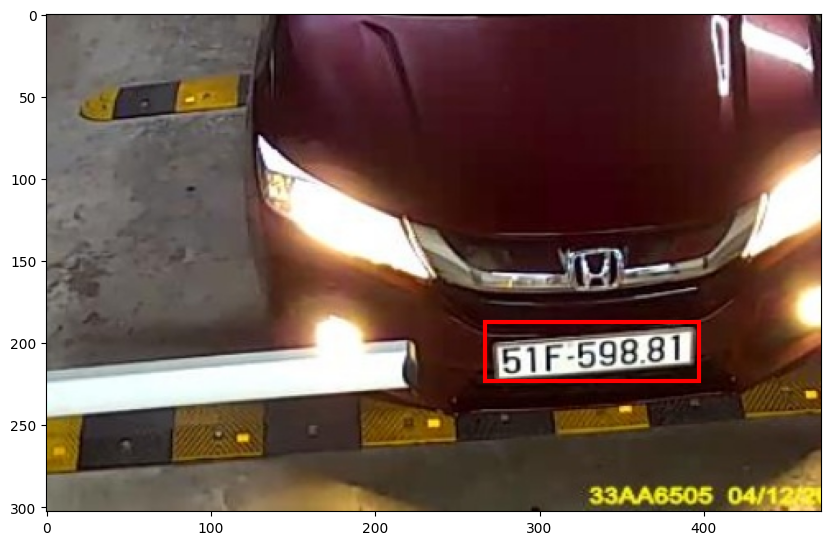

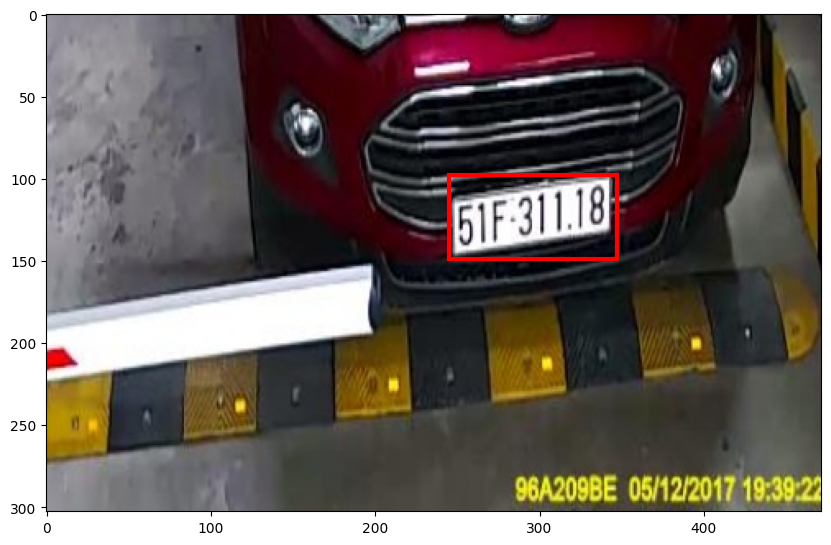

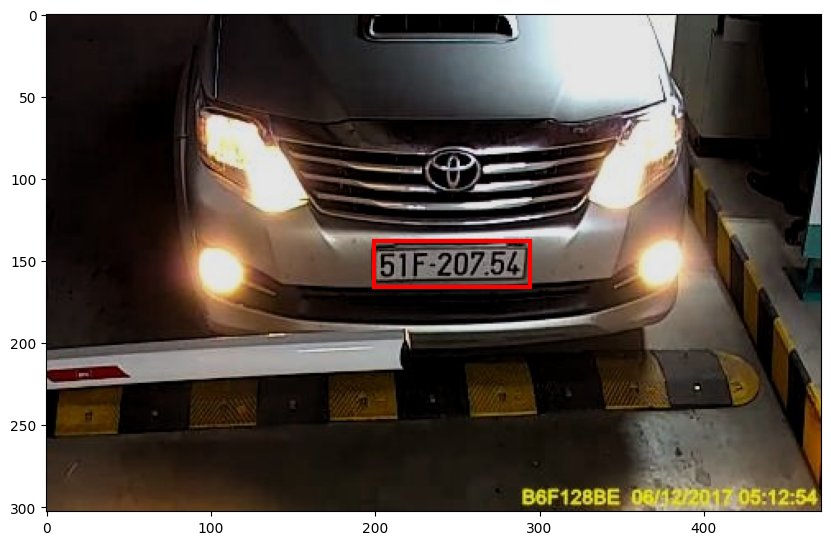

In [ ]:
count = 3
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)

In [ ]:
import os
import xml.etree.ElementTree as ET
import shutil
import random

In [ ]:
import os

directory_path = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages'

all_items = os.listdir(directory_path)

files = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]

num_files = len(files)

print(f"Number of files in '{directory_path}': {num_files}")

Number of files in '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages': 8308


In [ ]:
from IPython.display import display
from glob import glob
root_path = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/JPEGImages/*'
images_data = glob(root_path)

In [ ]:
def convert_annotation(xml_path, img_path, output_label_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract image dimensions
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        # Open output file
        with open(output_label_path, 'w') as out_file:
            for obj in root.iter('object'):
                # Get class name (assuming 'licence' is class 0)
                cls_name = obj.find('name').text
                if cls_name == 'plate':
                    cls_id = 0
                else:
                    continue

                # Get bounding box coordinates
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                     float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
                bb = (b[0] + b[2]) / 2 / w, (b[1] + b[3]) / 2 / h, (b[2] - b[0]) / w, (b[3] - b[1]) / h

                # Write to output file in YOLO format
                out_file.write(str(cls_id) + ' ' + ' '.join([str(a) for a in bb]) + '\n')

    except Exception as e:
        print(f'Error processing {xml_path}: {e}')

In [ ]:
def main():
    # Directories
    base_dir = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/'
    img_dir = os.path.join(base_dir, 'JPEGImages')
    xml_dir = os.path.join(base_dir, 'Annotations')

    train_img_output_dir = os.path.join(base_dir, 'train/images')
    train_label_output_dir = os.path.join(base_dir, 'train/labels')
    val_img_output_dir = os.path.join(base_dir, 'val/images')
    val_label_output_dir = os.path.join(base_dir, 'val/labels')

    # Create output directories if they don't exist
    for dir_path in [train_img_output_dir, train_label_output_dir, val_img_output_dir, val_label_output_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
     # Process each XML file
    xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]
    total_files = len(xml_files)
    train_split = int(0.8 * total_files)  # 80% for training

    random.shuffle(xml_files)

    for idx, xml_file in enumerate(xml_files):
        img_file = xml_file.replace('.xml', '.jpg')
        if os.path.exists(os.path.join(img_dir, img_file)):
            if idx < train_split:
                img_output_path = os.path.join(train_img_output_dir, img_file)
                label_output_path = os.path.join(train_label_output_dir, img_file.replace('.jpg', '.txt'))
            else:
                img_output_path = os.path.join(val_img_output_dir, img_file)
                label_output_path = os.path.join(val_label_output_dir, img_file.replace('.jpg', '.txt'))

            # Copy image to respective directory
            shutil.copy(os.path.join(img_dir, img_file), img_output_path)

            # Convert annotation
            convert_annotation(os.path.join(xml_dir, xml_file), img_output_path, label_output_path)


main()

Installing YOLO


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 234MB/s]


In [ ]:
import yaml

In [ ]:
config = {
    'path': '/content/drive/My Drive/voc_plate_dataset/',
    'train': 'train/images',
    'val': 'val/images',
    'nc': 1,
    'names': ['plate'],

}

In [ ]:
yaml_file_path = '/content/drive/My Drive/voc_plate_dataset/config.yaml'

with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(config, yaml_file)

print(f"YAML configuration file saved at: {yaml_file_path}")

YAML configuration file saved at: /content/drive/My Drive/voc_plate_dataset/config.yaml


In [ ]:
results = model.train(data='/content/dataset/voc_plate_dataset/config.yaml',
                      epochs=50,
                      imgsz=640,
                      pretrained = True ,
                      name= "license_plate_detection_3",
                      patience = 35,
                      flipud=0.5,
                      batch = 32,
                      optimizer = 'Adam',
                      augment = True
                      )

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/dataset/voc_plate_dataset/config.yaml, epochs=50, patience=35, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=license_plate_detection_32, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tru

In [ ]:
import shutil

source_directory = '/content/runs'
destination_directory = '/content/drive/MyDrive/License plate detection/'

shutil.copytree(source_directory, destination_directory)

'/content/drive/MyDrive/License plate detection/'

In [ ]:
results=model.val()

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/labels.cache... 601 images, 0 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:16<00:00,  1.17it/s]
                   all        601        605      0.984      0.977      0.994      0.686
Speed: 0.2ms preprocess, 16.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/license_plate_detection_322


In [ ]:
for i in [0.25,0.15,0.05]:
  results = model.val(name= f'confidence: {i}', conf= i , iou=0.8)

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/labels.cache... 601 images, 0 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]
                   all        601        605       0.98      0.954      0.986      0.694
Speed: 0.2ms preprocess, 16.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/confidence: 0.25
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/labels.cache... 601 images, 0 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<

In [ ]:
import cv2
from glob import glob

In [ ]:
root_path = '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(12,10))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')

In [ ]:
print(random_image)

['/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlateGen204.jpg', '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlate272.jpg', '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/images/boderquandoi76.jpg', '/content/drive/My Drive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlateGen1463.jpg']


In [ ]:
from google.colab.patches import cv2_imshow

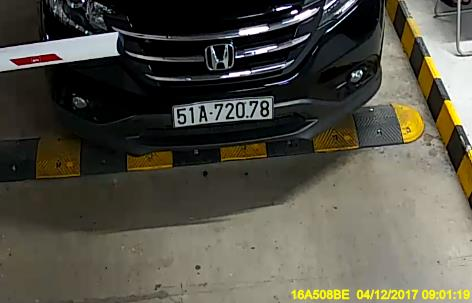

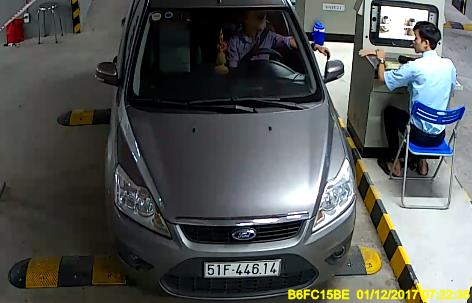

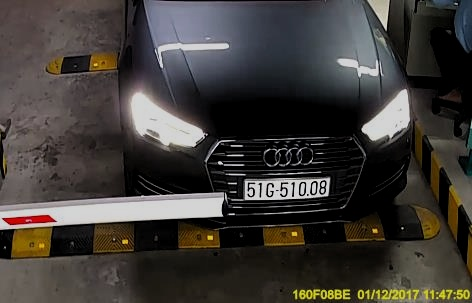

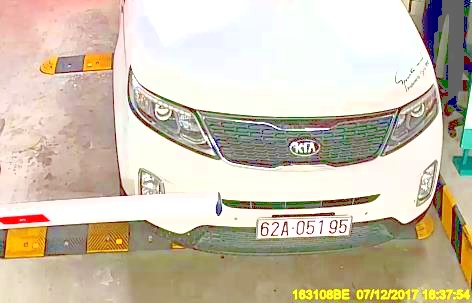

In [ ]:
root_path = '/content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(12,10))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    cv2_imshow(cv2.imread(random_image[i]))
    plt.axis('off')

In [ ]:
images = []
for i in range(num_samples):
    yolo_outputs = model.predict(random_image[i])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f'In this image {len(box)} License plate has been detected.')
        print(f'License {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------------------------------------------')

    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])


image 1/1 /content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlate37.jpg: 416x640 1 plate, 76.9ms
Speed: 5.0ms preprocess, 76.9ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlate804.jpg: 416x640 1 plate, 47.0ms
Speed: 2.3ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlateGen1824.jpg: 416x640 1 plate, 39.8ms
Speed: 1.8ms preprocess, 39.8ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/CarLongPlateGen1747.jpg: 416x640 1 plate, 39.2ms
Speed: 2.0ms preprocess, 39.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [169.2864532470703, 95.05494689941406, 278.133056640625, 127.91726684570312]
Confidence is: 0.78
-------------------------------------------
**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [201.2364501953125, 257.0428466796875, 282.723388671875, 280.6418762207031]
Confidence is: 0.82
-------------------------------------------
**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [240.2734832763672, 173.92649841308594, 332.28399658203125, 202.0134735107422]
Confidence is: 0.81
-------------------------------------------
**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [253.9849853515625, 211.49676513671875, 355.0282897949219, 241.9574432373047]
Confidence is: 0.8
-------------------------------------------

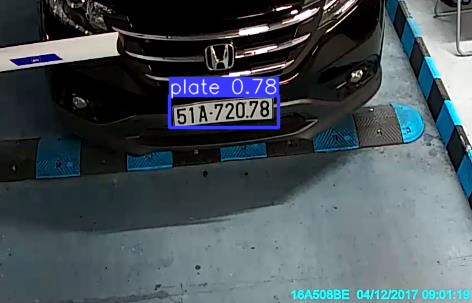

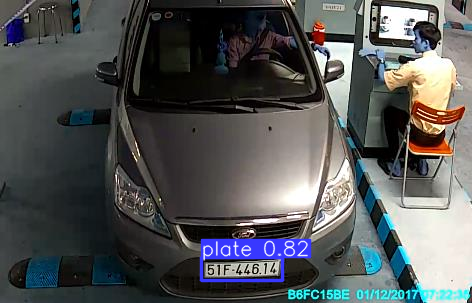

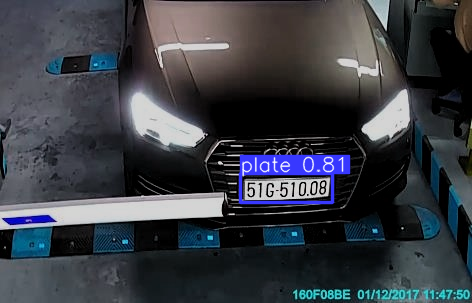

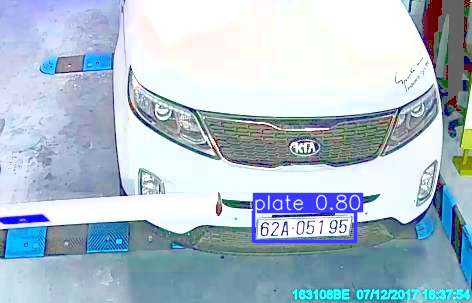

In [ ]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images):
    plt.subplot(2, 2, i + 1)
    cv2_imshow(img)
    plt.axis('off')

plt.show()

Section : Character recoognition using OCR

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
import cv2
import pytesseract
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

In [ ]:
import easyocr

reader = easyocr.Reader(['en'])  # Initialize EasyOCR with the desired language(s)

def extract_text_from_image(image, coordinates):
    xmin, ymin, xmax, ymax = map(int, coordinates)
    roi = image[ymin:ymax, xmin:xmax]

    # Use EasyOCR to extract text
    results = reader.readtext(roi)
    extracted_text = ' '.join(result[1] for result in results)

    return extracted_text.strip()


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete


0: 416x640 1 plate, 224.2ms
Speed: 6.5ms preprocess, 224.2ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 640)


**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [215.49017333984375, 200.52163696289062, 329.93438720703125, 234.65968322753906]
Confidence is: 0.79
Extracted text from license plate: 6622403
--------------------------------


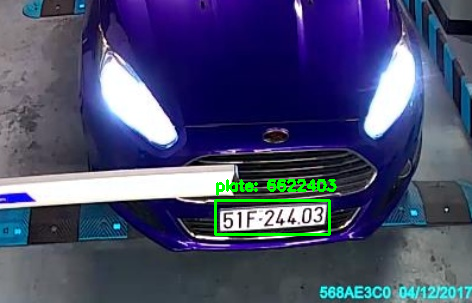


0: 416x640 1 plate, 181.3ms
Speed: 2.5ms preprocess, 181.3ms inference, 7.1ms postprocess per image at shape (1, 3, 416, 640)


**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [259.6185302734375, 249.48780822753906, 344.00689697265625, 273.1549987792969]
Confidence is: 0.81
Extracted text from license plate: 6F.795.12
--------------------------------


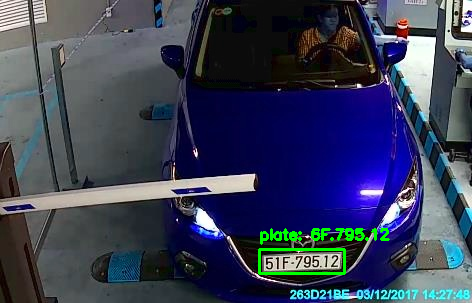


0: 416x640 1 plate, 91.1ms
Speed: 5.6ms preprocess, 91.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 640)


**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [148.5930633544922, 186.6959228515625, 272.1316223144531, 223.78240966796875]
Confidence is: 0.78
Extracted text from license plate: 6F-521.70
--------------------------------


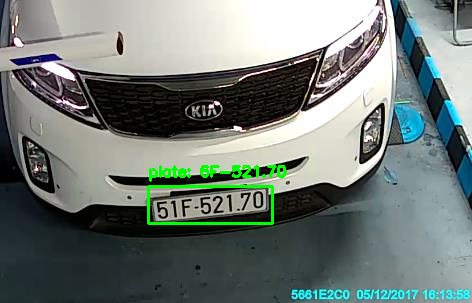


0: 416x640 1 plate, 69.6ms
Speed: 2.6ms preprocess, 69.6ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


**********************
In this image 1 License plate has been detected.
License 1 is: plate
Coordinates are: [269.05029296875, 213.38670349121094, 371.76751708984375, 242.95484924316406]
Confidence is: 0.78
Extracted text from license plate: 67F.075.68
--------------------------------


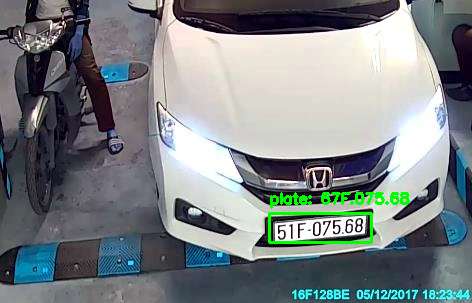

In [ ]:
root_path = '/content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image_paths = random.sample(images_data, num_samples)
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    image_np = cv2.imread(random_image_paths[i])  # Use random_image_paths instead of random_image
    yolo_outputs = model.predict(image_np)
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f'In this image {len(box)} License plate has been detected.')
        print(f'License {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')

        # Extract text using OCR
        extracted_text = extract_text_from_image(image_np, coordinates)
        print(f'Extracted text from license plate: {extracted_text}')

        # Append bounding box and text to the image
        image_with_bb = image_np.copy()
        x1, y1, x2, y2 = map(int, coordinates)
        cv2.rectangle(image_with_bb, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(image_with_bb, f'{labels}: {extracted_text}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        print('--------------------------------')
        plt.subplot(2, 2, i + 1)
        cv2_imshow(cv2.cvtColor(image_with_bb, cv2.COLOR_BGR2RGB))  # Display the image with bounding box and text
        plt.axis('off')

plt.show()


Section: Character segmentation to extract text on license plate

In [ ]:
def crop(img, box):
  box.xyxy[0]


0: 416x640 1 plate, 120.3ms
Speed: 3.4ms preprocess, 120.3ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


**********************
[229.6214141845703, 122.3265380859375, 343.1840515136719, 184.67315673828125]
122 306 229 572


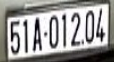


0: 448x640 1 plate, 118.7ms
Speed: 5.0ms preprocess, 118.7ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)


**********************
[302.7969055175781, 240.02328491210938, 358.6350402832031, 262.6105041503906]
240 502 302 660



0: 416x640 1 plate, 97.5ms
Speed: 4.4ms preprocess, 97.5ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 640)


**********************
[219.54920959472656, 219.338623046875, 316.1457824707031, 246.52345275878906]
219 465 219 535



0: 416x640 1 plate, 51.2ms
Speed: 3.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


**********************
[152.44203186035156, 245.29759216308594, 258.2039489746094, 277.7532653808594]
245 522 152 410


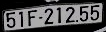

In [ ]:
root_path = '/content/drive/MyDrive/voc_plate_dataset/voc_plate_dataset/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image_paths = random.sample(images_data, num_samples)
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    image_np = cv2.imread(random_image_paths[i])  # Use random_image_paths instead of random_image
    yolo_outputs = model.predict(image_np)
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
      cor = box[j].xyxy.tolist()[0]
      #print(cor)
      left =int(cor[0])
      top =int(cor[1])
      width = int(cor[2])
      height = int(cor[3])


      # calculate bottom and right
      bottom = top + height
      right = left + width
      print(cor)
      print(top,bottom,left,right)
      cropped = image_np[top:height, left:width].copy()
      cv2_imshow(cropped)



plt.show()

In [ ]:
!cp ./yolov8n.pt ./drive/MyDrive/

In [ ]:
!cp ./yolov8s.pt ./drive/MyDrive/

In [ ]:
!cp -r ./runs ./drive/MyDrive/